### Dataset Structure

The dataset is already in YOLOv11 format and includes:

* train, valid, and test folders
* Each with images/ and labels/ subfolders
* A data.yaml file with class name and path definitions
* Class count: 1 (needle)

In [ ]:
!pip install ultralytics --upgrade

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Needle_detection/

/content/drive/MyDrive/Needle_detection


In [4]:
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load YOLOv11m (pretrained on COCO)
model = YOLO('yolo11m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Exploratory Data Analysis (EDA)

Before training our object detection model, we want to:
- Understand how many images are in each dataset split
- Check if any label files are empty
- Visualize a sample with a bounding boxes
- Look at image sizes to confirm consistency

This helps us ensure data quality and avoid training problems later.

I removed 3 empty label files and their corresponding images from train/valid folders.
This ensures the model trains only on valid examples.

The data cleaning step is **repeatable and safe** to rerun as part of the notebook pipeline. It’s designed so that even if the dataset is already clean, it will make no changes.




In [35]:
train_labels = os.listdir('train/labels')
empty_labels = [lbl for lbl in train_labels if os.path.getsize(f"train/labels/{lbl}") == 0]

print(f"Total training labels: {len(train_labels)}")
print(f"Empty training labels: {len(empty_labels)}")

val_labels = os.listdir('valid/labels')
print(f"Total validation labels: {len(val_labels)}")
print(f"Empty validation labels: {sum(os.path.getsize(f'valid/labels/{l}') == 0 for l in val_labels)}")


Total training labels: 314
Empty training labels: 2
Total validation labels: 90
Empty validation labels: 1


In [36]:
total_boxes = 0

for label_file in train_labels:
    with open(f'train/labels/{label_file}', 'r') as f:
        lines = f.readlines()
        total_boxes += len(lines)

print(f"Total bounding boxes in training set: {total_boxes}")


Total bounding boxes in training set: 312


In [38]:
def remove_empty_labels(image_folder, label_folder):
    removed = 0
    for label_file in os.listdir(label_folder):
        label_path = os.path.join(label_folder, label_file)

        if os.path.getsize(label_path) == 0:  # If file is empty
            os.remove(label_path)
            image_name = label_file.replace(".txt", ".jpg")  # or .png
            image_path = os.path.join(image_folder, image_name)
            if os.path.exists(image_path):
                os.remove(image_path)
            removed += 1

    print(f"Removed {removed} empty label files and corresponding images.")

# Apply to train and val sets
remove_empty_labels("train/images", "train/labels")
remove_empty_labels("valid/images", "valid/labels")

Removed 2 empty label files and corresponding images.
Removed 1 empty label files and corresponding images.


In [9]:
import os

train_images = len(os.listdir('train/images'))
val_images   = len(os.listdir('valid/images'))
test_images  = len(os.listdir('test/images'))

print(f"Train images: {train_images}")
print(f"Validation images: {val_images}")
print(f"Test images: {test_images}")


Train images: 312
Validation images: 89
Test images: 43


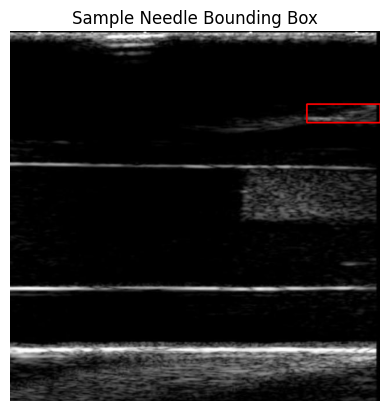

In [11]:
import cv2
import matplotlib.pyplot as plt

# Show one annotated image from train set
image_file = os.listdir('train/images')[0]
label_file = image_file.replace('.jpg', '.txt').replace('.jpeg', '.txt')  # adjust for extension

# Load image
img = cv2.imread(f'train/images/{image_file}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

# Draw boxes
with open(f'train/labels/{label_file}', 'r') as f:
    for line in f.readlines():
        cls, x_center, y_center, box_w, box_h = map(float, line.strip().split())
        # Convert YOLO to pixel coords
        x1 = int((x_center - box_w/2) * w)
        y1 = int((y_center - box_h/2) * h)
        x2 = int((x_center + box_w/2) * w)
        y2 = int((y_center + box_h/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(img)
plt.title("Sample Needle Bounding Box")
plt.axis('off')
plt.show()


In [12]:
!ls train/labels | wc -l  # Label files left after deletion
!ls train/images | wc -l  # Image files left after deletion

312
312


### YOLOv11 Model Setup

We're using the yolov11m.pt pretrained weights.
This gives the model a strong starting point from general object detection knowledge (COCO dataset), allowing it to adapt quickly to our medical use case (needle detection).

Model was loaded and trained using:

50 epochs

Batch size = 8

Early Stopping = 10

In [ ]:

model.train(
    data="data.yaml",
    epochs=50,                 # Keep it relatively small due to small dataset
    imgsz=640,                 # Resize for consistency
    batch=8,                   # Smaller batch due to small dataset
    patience=10,               # For early stopping
    name="needle_yolov11m",
    device=0
)

### Evaluation Metrics

After training, we examined:

Precision: How many predicted needles were correct
Recall: How many real needles were detected
mAP (mean Average Precision): Overall performance metric


In [14]:
results = model.val()

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 13.1±9.1 MB/s, size: 24.0 KB)


val: Scanning /content/drive/MyDrive/Needle_detection/valid/labels.cache... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.25it/s]


                   all         89         89      0.987      0.966      0.977      0.858
Speed: 1.8ms preprocess, 28.5ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/needle_yolov11m2


In [16]:
print("mAP@0.5:0.95:", results.box.map)
print("mAP@0.5:", results.box.map50)
print("Precision:", results.box.mp)
print("Recall:", results.box.mr)
print("Mean F1 Score:", sum(results.box.f1) / len(results.box.f1))

mAP@0.5:0.95: 0.858459419372903
mAP@0.5: 0.9767122288632782
Precision: 0.9866682821568139
Recall: 0.9662921348314607
Mean F1 Score: 0.9763739115676321


### Inference & Test Results

I used the best model (best.pt) to run predictions on the test set.
Outputs were saved with bounding boxes in runs/detect/predict/.

I visually inspected predictions to confirm:

*   The majority of boxes align correctly with the needle locations
*   I still need to familiarize myself more with ultrasound images to better identify false positives or subtle detection errors.

In [17]:
model = YOLO('runs/detect/needle_yolov11m/weights/best.pt')

In [ ]:
model.predict(source="test/images", save=True, save_txt=True, conf=0.25)
